# Challenge: Factors that affect life expectancy

Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which 
factors decrease it.

In [141]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [142]:
# read in US education data 
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_exp = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [143]:
# clean column labels
find_rep = {' ': '_',
            '/': '_'}

for item in find_rep:
    life_exp.columns = life_exp.columns.str.replace(item, find_rep[item])

life_exp.columns = map(str.lower, life_exp.columns)

In [176]:
# glance at the data
life_exp.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years,_thinness_5-9_years,income_composition_of_resources,schooling,pca_1
0,Afghanistan,2015,Developing,59154.004607,21.966825,2.631244,0.009961,4.428511,2013.783904,4.839565,14.589876,2.870100,78.510304,4.145291,40303.753373,0.087144,7.583549,36.573937,2.562397,2.642781,0.946888,25.328623,1.458413
1,Afghanistan,2014,Developing,46944.119751,22.270727,2.642828,0.009961,4.461230,1836.638852,4.440540,14.247530,2.883731,28787.746108,4.152151,35423.226678,0.087144,7.650197,21.635061,2.575072,2.651734,0.937201,24.971339,1.497000
2,Afghanistan,2013,Developing,46944.119751,22.157385,2.653978,0.009961,4.456849,1953.839524,4.373918,13.904075,2.896804,34519.051561,4.134987,38632.067241,0.087144,7.693224,36.339393,2.583398,2.660584,0.918003,24.615772,1.542895
3,Afghanistan,2012,Developing,46063.198635,22.308345,2.669952,0.009961,4.526195,2136.359304,5.213627,13.559479,2.913435,42644.475766,4.267695,43784.335547,0.087144,7.775964,28.776846,2.591627,2.673672,0.895902,24.261930,1.590993
4,Afghanistan,2011,Developing,45409.632304,22.420719,2.680137,0.009961,2.126425,2198.989757,5.244933,13.282956,2.929230,44402.886790,4.044989,45594.297413,0.087144,4.664629,28.084246,2.603796,2.682276,0.867948,23.210830,1.676246


In [145]:
# examine size of dataset
life_exp.shape

(2938, 22)

In [146]:
# examine the data types of each column
life_exp.dtypes

country                             object
year                                 int64
status                              object
life_expectancy_                   float64
adult_mortality                    float64
infant_deaths                        int64
alcohol                            float64
percentage_expenditure             float64
hepatitis_b                        float64
measles_                             int64
_bmi_                              float64
under-five_deaths_                   int64
polio                              float64
total_expenditure                  float64
diphtheria_                        float64
_hiv_aids                          float64
gdp                                float64
population                         float64
_thinness__1-19_years              float64
_thinness_5-9_years                float64
income_composition_of_resources    float64
schooling                          float64
dtype: object

### 1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

#### Deal with nan values

In [147]:
# how many nan values are there for each column?
life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                               19
total_expenditure                  226
diphtheria_                         19
_hiv_aids                            0
gdp                                448
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

#### Since this is time series data, my guess is that most trends will generally change in the same direction for each country.  As a result I will interpolate to fill na values for each country.

In [148]:
for col in life_exp.columns[3:]:
    for country in life_exp.country.unique():
        life_exp.loc[life_exp['country'] == country, col] = \
        life_exp.loc[life_exp['country'] == country, col].fillna(
        life_exp.loc[life_exp['country'] == country, col].interpolate())

In [149]:
# verify nan values are filled
# I'm still left with a large number of nan values

life_exp.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy_                    10
adult_mortality                     10
infant_deaths                        0
alcohol                            192
percentage_expenditure               0
hepatitis_b                        144
measles_                             0
_bmi_                               34
under-five_deaths_                   0
polio                                0
total_expenditure                  210
diphtheria_                          0
_hiv_aids                            0
gdp                                422
population                         652
_thinness__1-19_years               34
_thinness_5-9_years                 34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [150]:
# because I still have so many NaN values
# fill nan values for the entire column using interpolate
# instead of by column and country

for col in life_exp.columns[3:]:
    life_exp.loc[:, col] = \
    life_exp.loc[:, col].fillna(
    life_exp.loc[:, col].interpolate())

In [151]:
# how many nan values are there for each column?
# this method removed all nan values
life_exp.isna().sum()

country                            0
year                               0
status                             0
life_expectancy_                   0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles_                           0
_bmi_                              0
under-five_deaths_                 0
polio                              0
total_expenditure                  0
diphtheria_                        0
_hiv_aids                          0
gdp                                0
population                         0
_thinness__1-19_years              0
_thinness_5-9_years                0
income_composition_of_resources    0
schooling                          0
dtype: int64

#### Deal with outlier values

In [152]:
# identify columns that have at least one
# data point that lies outside the 99.7th percentile (3 standard deviations)
# for that column
columns_with_outliers = []

for column in life_exp.columns[3:]:
    if len(np.where(zscore(life_exp[column]) > 3)[0]) > 1:
        columns_with_outliers.append(column)
        print(column)
        print(len(np.where(zscore(life_exp[column]) > 3)[0]))

adult_mortality
40
infant_deaths
37
alcohol
4
percentage_expenditure
84
measles_
48
under-five_deaths_
34
total_expenditure
26
_hiv_aids
69
gdp
87
population
22
_thinness__1-19_years
53
_thinness_5-9_years
55


There are a lot of outliers beyond 3 standard deviations.  These seem to mostly be columns that don't have normal distributions.

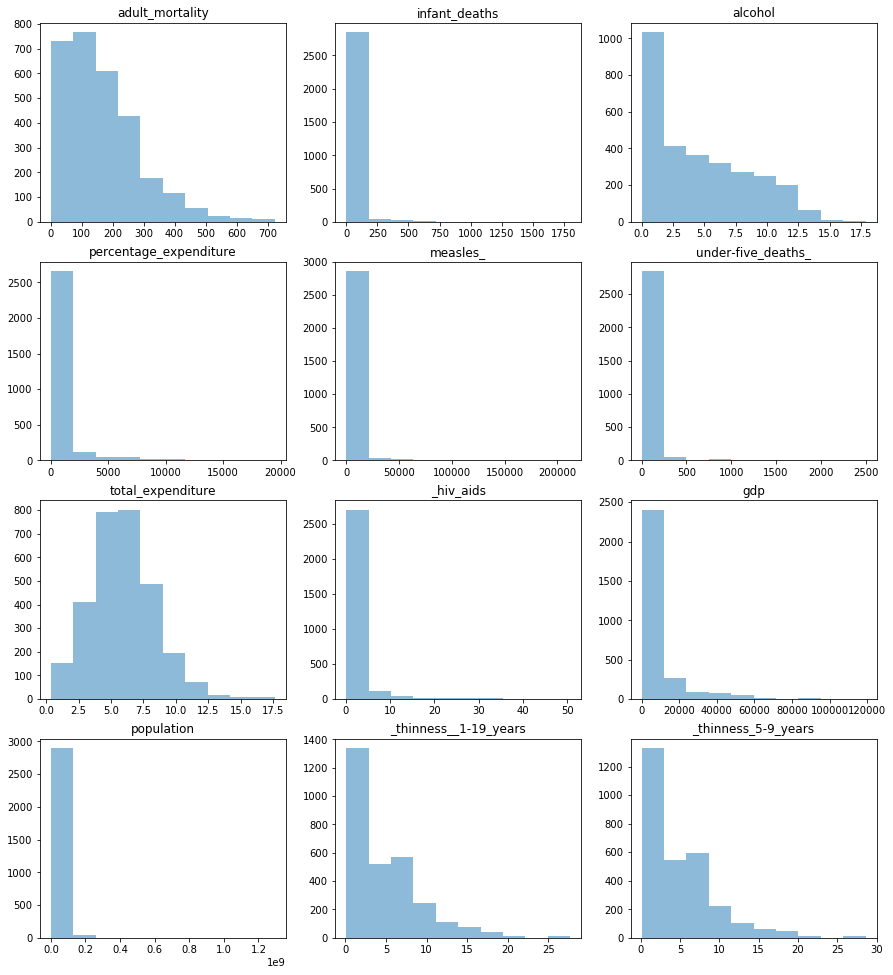

In [153]:
# show histogram for each outlier column
# to show the distribution of the data

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_with_outliers):
    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

In [154]:
# apply box cox to all variables
# but to be able to do this I need all variables to be positive

for column in life_exp.columns[3:]:
    life_exp[column],_ = boxcox(life_exp.loc[:,column] + 1)

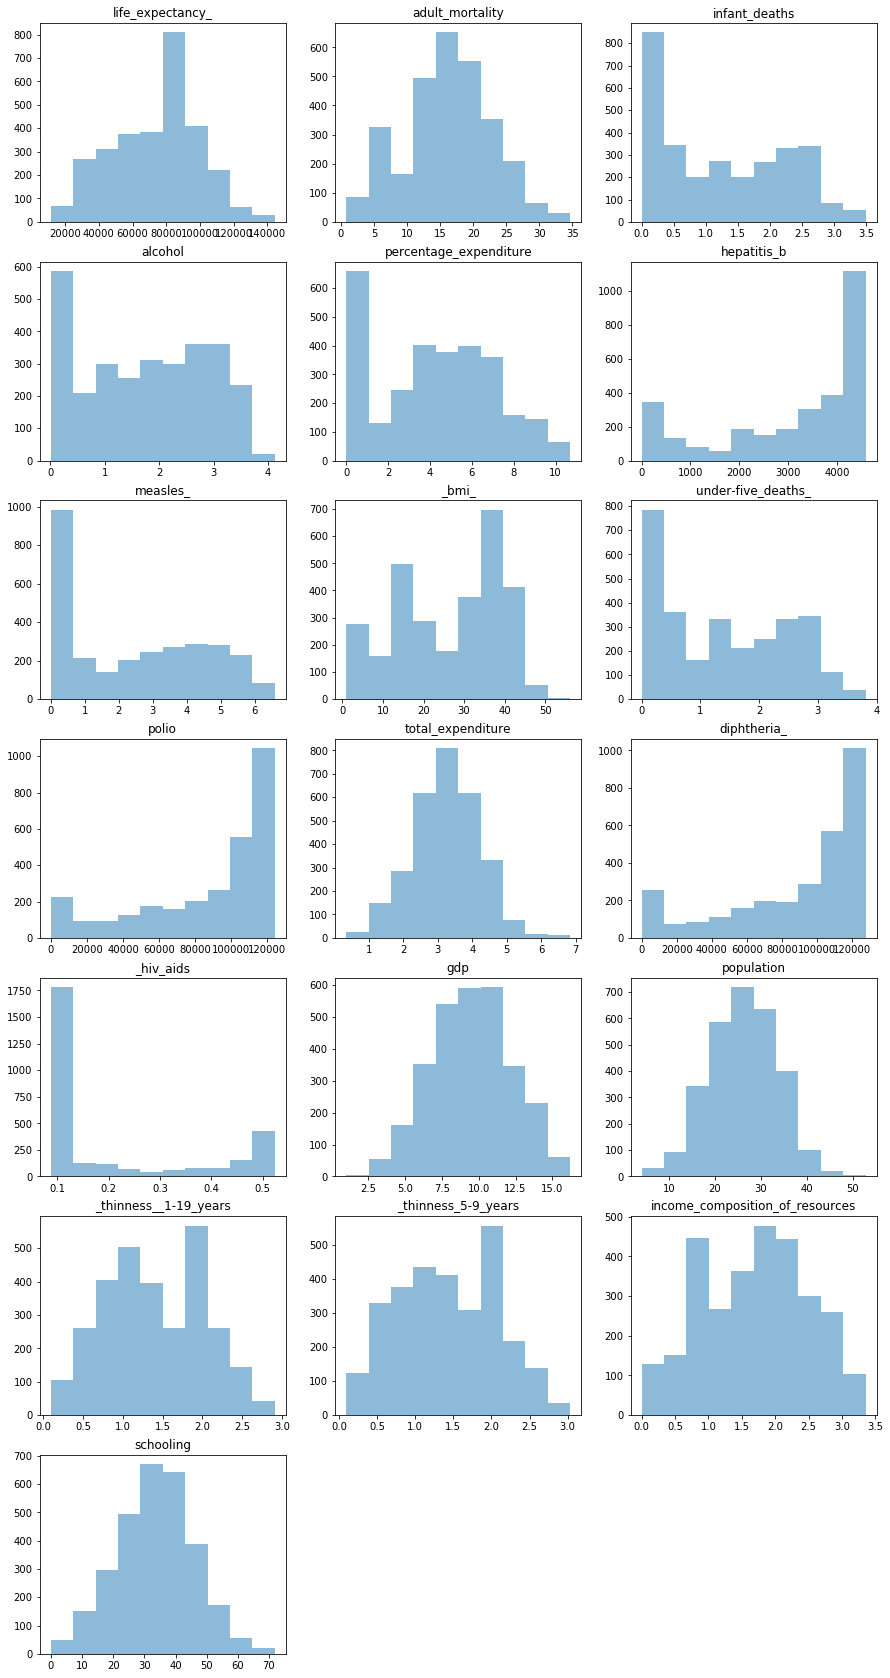

In [155]:
# show histogram for each column
# to show the distribution of the data
# to verify how much boxcox helped me

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.hist(life_exp[column], alpha=.5);

In [156]:
# look for outliers above 3 standard deviations
columns_with_outliers = []

for column in life_exp.columns[3:]:
    if len(np.where(zscore(life_exp[column]) > 3)[0]) > 1:
        columns_with_outliers.append(column)
        print(column)
        print(len(np.where(zscore(life_exp[column]) > 3)[0]))

total_expenditure
14
population
5
schooling
2


After using boxcox only three columns have outliers

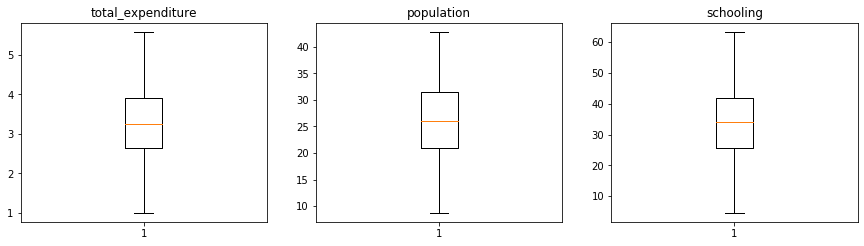

In [157]:
# compare against earlier histograms of outlier data
# the issues now is that the upper bound of each of  
# these has a whole bunch of observations because of the capping process

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(columns_with_outliers):

    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.boxplot(winsorize(life_exp[column], (.01, 0.01)));

Using winsorize after boxcox, it doesn't take much to shave off outliers.

In [158]:
# apply winsorization to all variables

for column in life_exp.columns[3:]:
    life_exp[column] = winsorize(life_exp.loc[:,column], (.01, 0.01))

### 2. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.


#### Univariate analysis

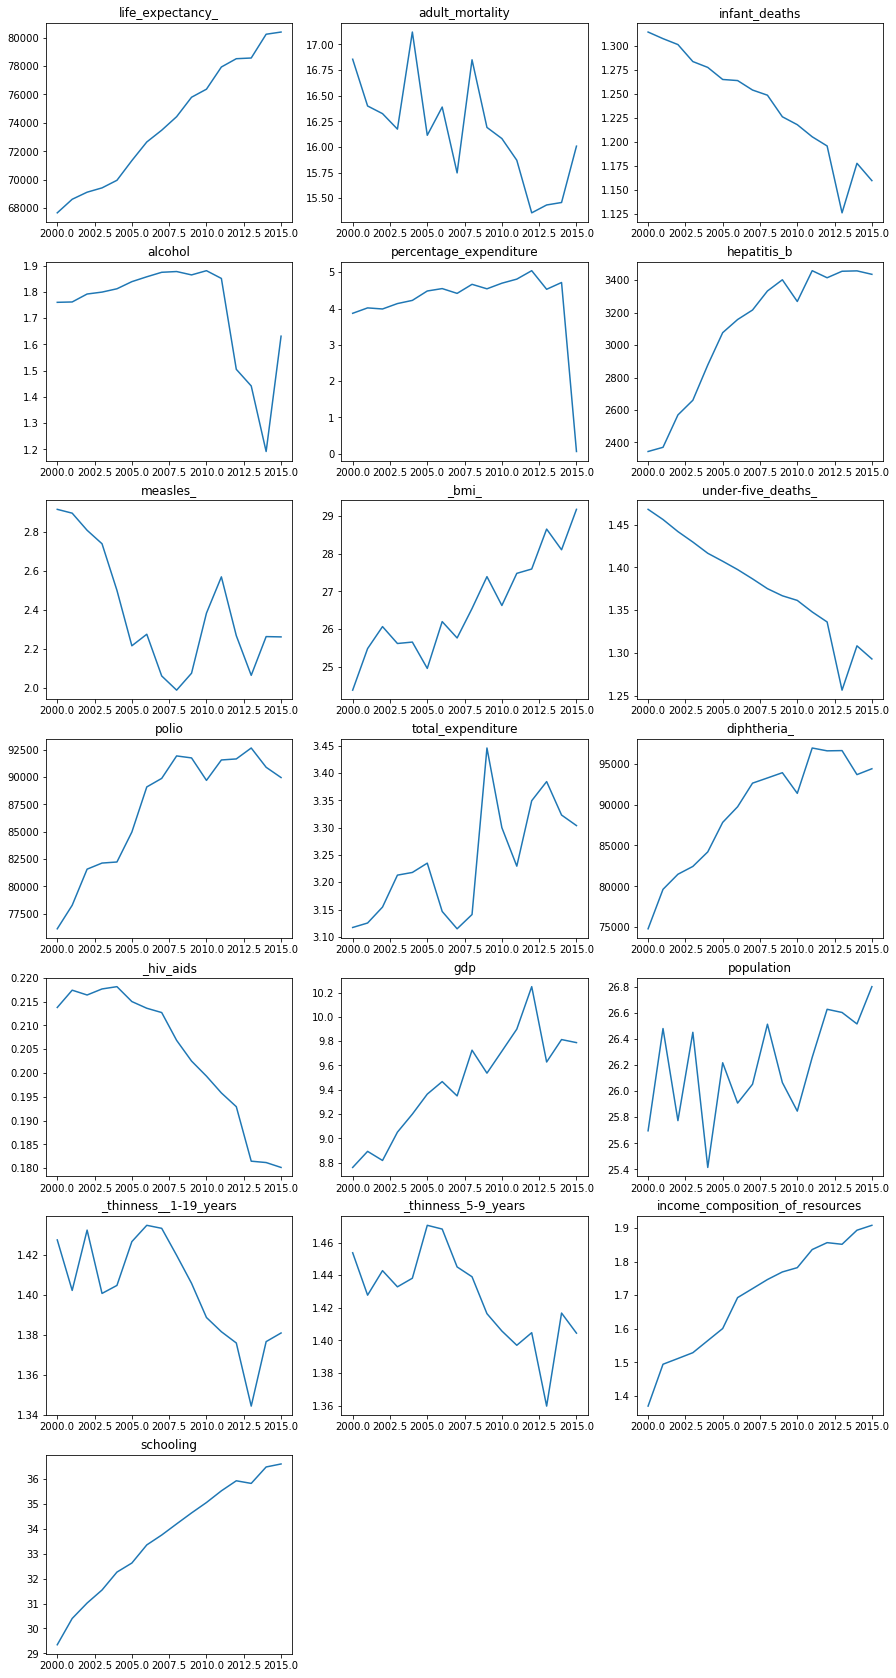

In [159]:
# plot each attribute over time
fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):
    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    x = life_exp[['year', 'life_expectancy_']].groupby('year').mean().index
    y = life_exp[['year', column]].groupby('year').mean().iloc[:,0]
    plt.plot(x, y);

Visually, schooling and income_composition_of_resources seem to be most correlated with life expectancy.

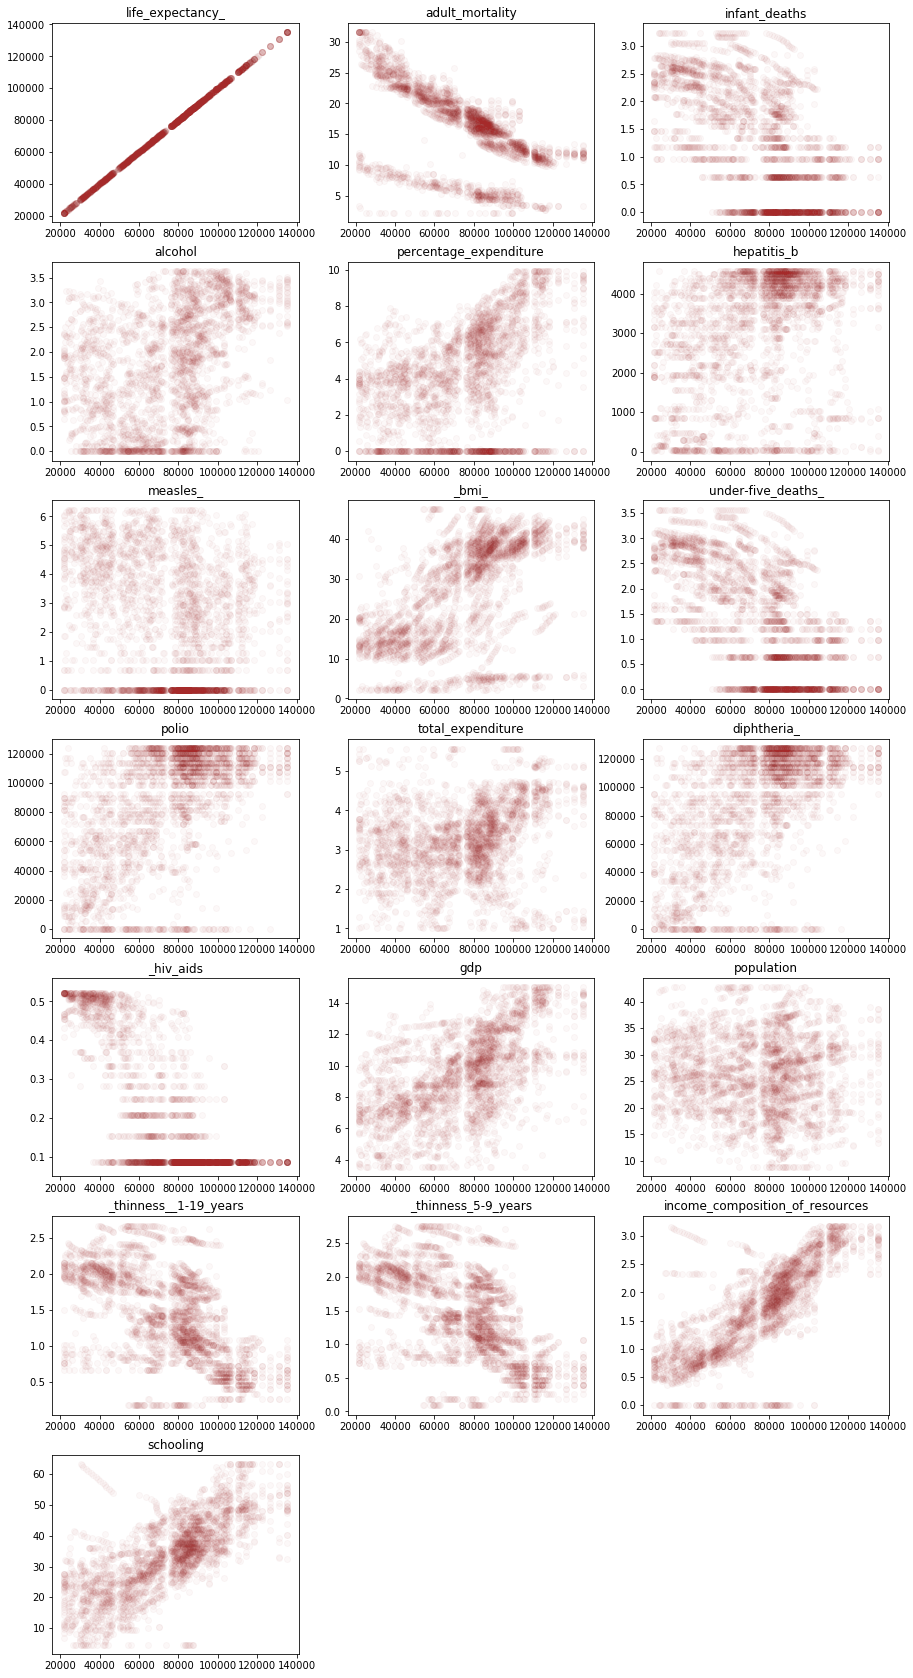

In [160]:
# create scatter plots
# contrasting each attribute against
# life expectancy

fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp.columns[3:]):
    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.scatter(life_exp['life_expectancy_'], life_exp[column], color='brown', alpha=.03);

Similar to time series plotting above, income_composition_of_resources and schooling seem to mimic the pattern of life_expectancy most closely.
Interesting that infant_deaths and under_5 deaths have a similar pattern.  Also, polio, diptheria, and hepatitis have similar patterns.

In [161]:
# which countries are associated with the highest life expectancy?
life_exp[['country','life_expectancy_']].groupby('country') \
    .mean().sort_values(by='life_expectancy_', ascending=False).head(10)

,life_expectancy_
country,
Japan,116483.335135
Iceland,116017.335899
Sweden,115846.154665
Switzerland,115701.289395
Italy,114521.803205
France,114484.181207
Spain,114078.129946
Australia,113676.667898
Canada,113295.829129


Many of these countries aren't especially wealthy, such as Spain, Iceland, or Australia.  The United States isn't even in the top 10.

In [162]:
# which countries are associated with the lowest life expectancy?
life_exp[['country','life_expectancy_']].groupby('country') \
    .mean().sort_values(by='life_expectancy_', ascending=True).head(10)

,life_expectancy_
country,
Sierra Leone,24583.644213
Central African Republic,26227.983095
Lesotho,26750.304969
Angola,26903.657919
Côte d'Ivoire,28941.838640
Chad,28992.726043
Malawi,29436.454267
Zimbabwe,30694.266361
Nigeria,30712.437589


Most of these countries are in Africa where where the largest contributors to death are probably AIDS and infant mortality.

#### Multivariate Analysis

In [163]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
income_composition_of_resources    0.787897
schooling                          0.740729
gdp                                0.581985
diphtheria_                        0.564541
polio                              0.556877
_bmi_                              0.547239
alcohol                            0.409169
percentage_expenditure             0.406432
hepatitis_b                        0.333557
total_expenditure                  0.230532
year                               0.162621
population                        -0.033467
measles_                          -0.285035
_thinness__1-19_years             -0.586509
adult_mortality                   -0.588914
_thinness_5-9_years               -0.593725
infant_deaths                     -0.600747
under-five_deaths_                -0.620659
_hiv_aids                         -0.774577
Name: life_expectancy_, dtype: float64

Schooling appears to be the most highly correlated with life expectancy.

### 3.  In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

#### Dataset Attributes - analysis of feature relevance to life expectancy.
1. <font color=red>Life expectancyLife Expectancy in age - this is the target variable</font>
1. Adult MortalityAdult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
1. infant deathsNumber of Infant Deaths per 1000 population
1. AlcoholAlcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
1. <font color=green>percentage expenditureExpenditure on health as a percentage of Gross Domestic Product per capita(%) - some countries may not be particularly efficient at producing positive outcomes through healthcare spending. however this attribute is definitely more usefull than total_expenditure below since that isn't scaled for each country.</font>
1. Hepatitis BHepatitis B (HepB) immunization coverage among 1-year-olds (%)
1. MeaslesMeasles - number of reported cases per 1000 population
1. <font color=green>BMIAverage Body Mass Index of entire population - this could go either way, countries with more resources may be prone to higher bmi which could be linked to diseases that shorten life expectancy, such as heart disease.  On the other hand, people are struggling with famine, who can't get enough food may suffer life shortening consequences too.</font> 
1. <font color=green>under-five deathsNumber of under-five deaths per 1000 population - a higher number of these will pull the life expectancy down since deaths in this category represent such small numbers.</font>
1. PolioPolio (Pol3) immunization coverage among 1-year-olds (%)
1. Total expenditureGeneral government expenditure on health as a percentage of total government expenditure (%)
1. DiphtheriaDiphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
1. HIV/AIDSDeaths per 1 000 live births HIV/AIDS (0-4 years)
1. <font color=green>GDPGross Domestic Product per capita (in USD) - similar to BMI above, a country with a higher life expectancy will probably be a country with a medium level of financial resources.</font>
1. <font color=green>PopulationPopulation of the country - this could be usefull to scale countries statistics.  As it is each country is representing a similar weight with its statistics.  A country with a small population and low life expectancy should not carry the same weight as a much larger country with a low life expectancy</font>
1. thinness 1-19 yearsPrevalence of thinness among children and adolescents for Age 10 to 19 (% )
1. thinness 5-9 yearsPrevalence of thinness among children for Age 5 to 9(%)
1. Income composition of resourcesHuman Development Index in terms of income composition of resources (index ranging from 0 to 1)
1. <font color=green>SchoolingNumber of years of Schooling(years) - higher education is associated with higher earning power, which would be represented in higher gdp.  However more wealthy countries may struggle with issues like obesity.</font>

In [213]:
# bmis that are either too low
# or too high will reduce life expectancy
# segment bmi data into 3 bins
life_exp["bmi_bins"] = pd.qcut(life_exp._bmi_, 3, labels=['low_bmi', 'med_bmi', 'high_bmi'])

In [214]:
life_exp.bmi_bins.value_counts()

med_bmi     985
low_bmi     980
high_bmi    973
Name: bmi_bins, dtype: int64

In [236]:
# pd.get_dummies(df, prefix=['col1', 'col2'])

bmi_dummies = pd.get_dummies(life_exp.bmi_bins, drop_first=False) 

In [237]:
bmi_dummies.head()

bmi_bins,low_bmi,med_bmi,high_bmi
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [252]:
# create df to hold attributes I feel best predictors
life_exp_features = life_exp[['life_expectancy_', 'schooling', 'income_composition_of_resources', 'gdp', 'pca_1']].copy()
life_exp_features = pd.concat([life_exp_features, bmi_dummies[1:]], axis=1)

In [253]:
life_exp_features.corr()

,life_expectancy_,schooling,income_composition_of_resources,gdp,pca_1,low_bmi,med_bmi,high_bmi
life_expectancy_,1.000000,0.740729,0.787897,0.581985,-0.786735,-0.491911,-0.045762,0.538574
schooling,0.740729,1.000000,0.872146,0.605659,-0.926540,-0.439564,-0.102729,0.543287
income_composition_of_resources,0.787897,0.872146,1.000000,0.650806,-0.942724,-0.442770,-0.102523,0.546291
gdp,0.581985,0.605659,0.650806,1.000000,-0.823829,-0.381843,-0.014568,0.397045
pca_1,-0.786735,-0.926540,-0.942724,-0.823829,1.000000,0.469632,0.084025,-0.554641
low_bmi,-0.491911,-0.439564,-0.442770,-0.381843,0.469632,1.000000,-0.502300,-0.497703
med_bmi,-0.045762,-0.102729,-0.102523,-0.014568,0.084025,-0.502300,1.000000,-0.499993
high_bmi,0.538574,0.543287,0.546291,0.397045,-0.554641,-0.497703,-0.499993,1.000000


In [246]:
life_exp.iloc[:, 3:19]

,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under-five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness__1-19_years
0,59154.004607,21.966825,2.631244,0.009961,4.428511,2013.783904,4.839565,14.589876,2.870100,78.510304,4.145291,40303.753373,0.087144,7.583549,36.573937,2.562397
1,46944.119751,22.270727,2.642828,0.009961,4.461230,1836.638852,4.440540,14.247530,2.883731,28787.746108,4.152151,35423.226678,0.087144,7.650197,21.635061,2.575072
2,46944.119751,22.157385,2.653978,0.009961,4.456849,1953.839524,4.373918,13.904075,2.896804,34519.051561,4.134987,38632.067241,0.087144,7.693224,36.339393,2.583398
3,46063.198635,22.308345,2.669952,0.009961,4.526195,2136.359304,5.213627,13.559479,2.913435,42644.475766,4.267695,43784.335547,0.087144,7.775964,28.776846,2.591627
4,45409.632304,22.420719,2.680137,0.009961,2.126425,2198.989757,5.244933,13.282956,2.929230,44402.886790,4.044989,45594.297413,0.087144,4.664629,28.084246,2.603796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,21749.615039,31.552992,2.298394,2.028192,0.000000,2198.989757,2.861049,19.937863,2.589520,42644.475766,3.781619,40303.753373,0.523197,7.233814,32.985007,2.117452
2934,21749.615039,31.552992,2.281904,1.945598,0.000000,30.442954,4.774275,19.675554,2.578915,113.776683,3.555679,45594.297413,0.523197,7.230724,32.944795,2.148149
2935,21749.615039,11.969040,2.264640,2.046942,0.000000,2525.558595,4.197722,19.412764,2.568000,53889.550406,3.559453,51309.224097,0.523197,4.539168,19.159044,0.761873
2936,21749.615039,31.552992,2.264640,1.118408,0.000000,2732.223679,4.475991,19.149486,2.556757,60155.336947,3.418168,59613.844457,0.523197,7.495469,32.868693,0.916657


#### PCA with positively correlated variables.

In [282]:
# use principal component analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select 2 features that I think are most correlated with life expectancy
X = StandardScaler().fit_transform(life_exp[['schooling', 'income_composition_of_resources', 'gdp']])
sklearn_pca = PCA(n_components=1)

# what is happening by the creation of this new column?
life_exp["pca_1"] = sklearn_pca.fit_transform(X)

# ratio of total variance in the dataset explained 
# by each component from PCA sklearn
sklearn_pca.explained_variance_ratio_

array([0.80863327])

#### PCA with disease variables.

In [283]:
# use principal component analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select 2 features that I think are most correlated with life expectancy
X = StandardScaler().fit_transform(life_exp[['diphtheria_', 'hepatitis_b',
                                             '_hiv_aids', 'measles_']])
sklearn_pca = PCA(n_components=1)

# what is happening by the creation of this new column?
life_exp["pca_3"] = sklearn_pca.fit_transform(X)

# ratio of total variance in the dataset explained 
# by each component from PCA sklearn
sklearn_pca.explained_variance_ratio_

array([0.54126021])

#### PCA with negatively correlated variables.

In [203]:
# use principal component analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select 2 features that I think are most correlated with life expectancy
X = StandardScaler().fit_transform(life_exp[['_hiv_aids', 
                                           'under-five_deaths_',
                                            'infant_deaths']])
sklearn_pca = PCA(n_components=1)

# what is happening by the creation of this new column?
life_exp["pca_2"] = sklearn_pca.fit_transform(X)

# ratio of total variance in the dataset explained 
# by each component from PCA sklearn
sklearn_pca.explained_variance_ratio_

array([0.78224359])

In [204]:
# which of the attributes correlates most strongly with life_expectancy?
life_exp.corr().iloc[:,1].sort_values(ascending=False)

life_expectancy_                   1.000000
income_composition_of_resources    0.787897
schooling                          0.740729
gdp                                0.581985
diphtheria_                        0.564541
polio                              0.556877
_bmi_                              0.547239
alcohol                            0.409169
percentage_expenditure             0.406432
hepatitis_b                        0.333557
total_expenditure                  0.230532
year                               0.162621
population                        -0.033467
measles_                          -0.285035
_thinness__1-19_years             -0.586509
adult_mortality                   -0.588914
_thinness_5-9_years               -0.593725
infant_deaths                     -0.600747
under-five_deaths_                -0.620659
pca_2                             -0.732205
_hiv_aids                         -0.774577
pca_1                             -0.789981
Name: life_expectancy_, dtype: f

I'm confused why life expectancy(my target variable) is negatively correlated with the aggregate of my principle components.  But each of the attributes on their own are positively correlated.

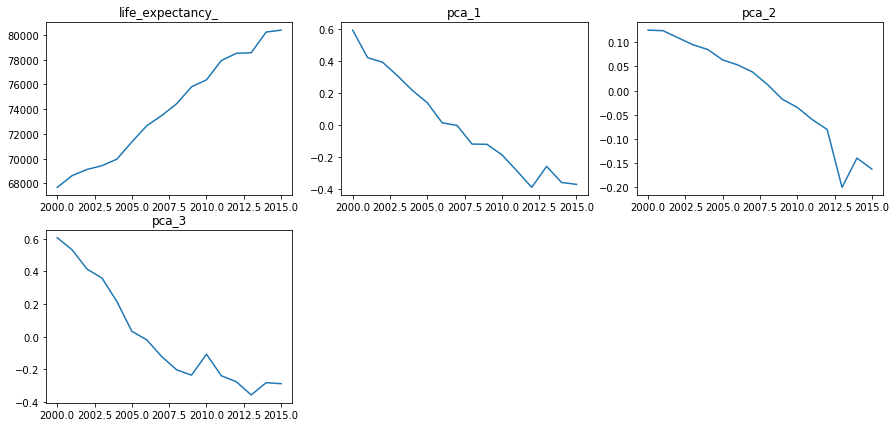

In [290]:
# plot each attribute over time
# and compare how they relate to life expectancy
fig = plt.figure(figsize=(15, 7))

for i, column in enumerate(life_exp[['life_expectancy_', 'pca_1', 'pca_2', 'pca_3']]):
    plt.subplot(2, 3, i+1)
    plt.title(column)
    x = life_exp[['year', 'life_expectancy_']].groupby('year').mean().index
    y = life_exp[['year', column]].groupby('year').mean().iloc[:,0]
    plt.plot(x, y);

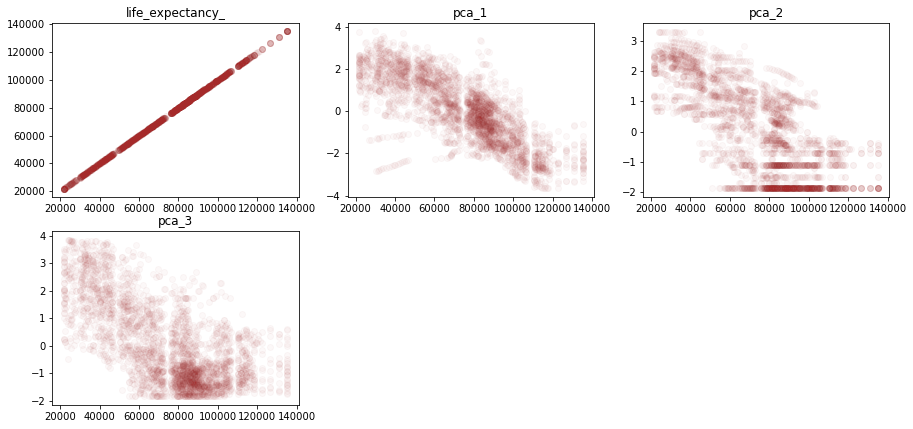

In [291]:
# scatterplot comparison between
# target variable and positively correlated variables(pca_1)
# and negatively correlated variable(pca_2)
fig = plt.figure(figsize=(15, 30))

for i, column in enumerate(life_exp[['life_expectancy_', 'pca_1', 'pca_2', 'pca_3']]):
    plt.subplot(ceil(len(life_exp.columns[3:])/3), 3, i+1)
    plt.title(column)
    plt.scatter(life_exp['life_expectancy_'], life_exp[column], color='brown', alpha=.03);


### 4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.


Based on my analysis, I found that 'schooling' and 'income_composition_of_resources' were the two strongest predictors of life expectancy, with gdp following farther behind.

In addition, I binned the bmi data into three bins - low, medium, and high.  My reasoning being that countries with lots of people having low and high bmis probably are less healthy than countries with medium bmis.  After examining the correlation of each of these bmi bins, however, I discovered that only the countries with the highest bmis were positively correlated with life expectancy, and that the correlation of the countries with the highest bmis was lower than simply using the un-feature engineered bmi column originally in the dataset. This was disappointing to me.

When performing PCA analysis, the aggregate of the top 3 most correlated features('schooling', 'income_composition_of_resources', 'gdp') resulted in a principal component that explained 81% of the total variance.  However when correlating pca_1 against life expectancy, it was strongly negatively correlated.  As a result it doesn't seem wise to use pca_1 as a feature for modeling.

In [259]:
life_exp_features.corr()

,life_expectancy_,schooling,income_composition_of_resources,gdp,pca_1,low_bmi,med_bmi,high_bmi
life_expectancy_,1.000000,0.740729,0.787897,0.581985,-0.786735,-0.491911,-0.045762,0.538574
schooling,0.740729,1.000000,0.872146,0.605659,-0.926540,-0.439564,-0.102729,0.543287
income_composition_of_resources,0.787897,0.872146,1.000000,0.650806,-0.942724,-0.442770,-0.102523,0.546291
gdp,0.581985,0.605659,0.650806,1.000000,-0.823829,-0.381843,-0.014568,0.397045
pca_1,-0.786735,-0.926540,-0.942724,-0.823829,1.000000,0.469632,0.084025,-0.554641
low_bmi,-0.491911,-0.439564,-0.442770,-0.381843,0.469632,1.000000,-0.502300,-0.497703
med_bmi,-0.045762,-0.102729,-0.102523,-0.014568,0.084025,-0.502300,1.000000,-0.499993
high_bmi,0.538574,0.543287,0.546291,0.397045,-0.554641,-0.497703,-0.499993,1.000000


(8.0, 0.0)

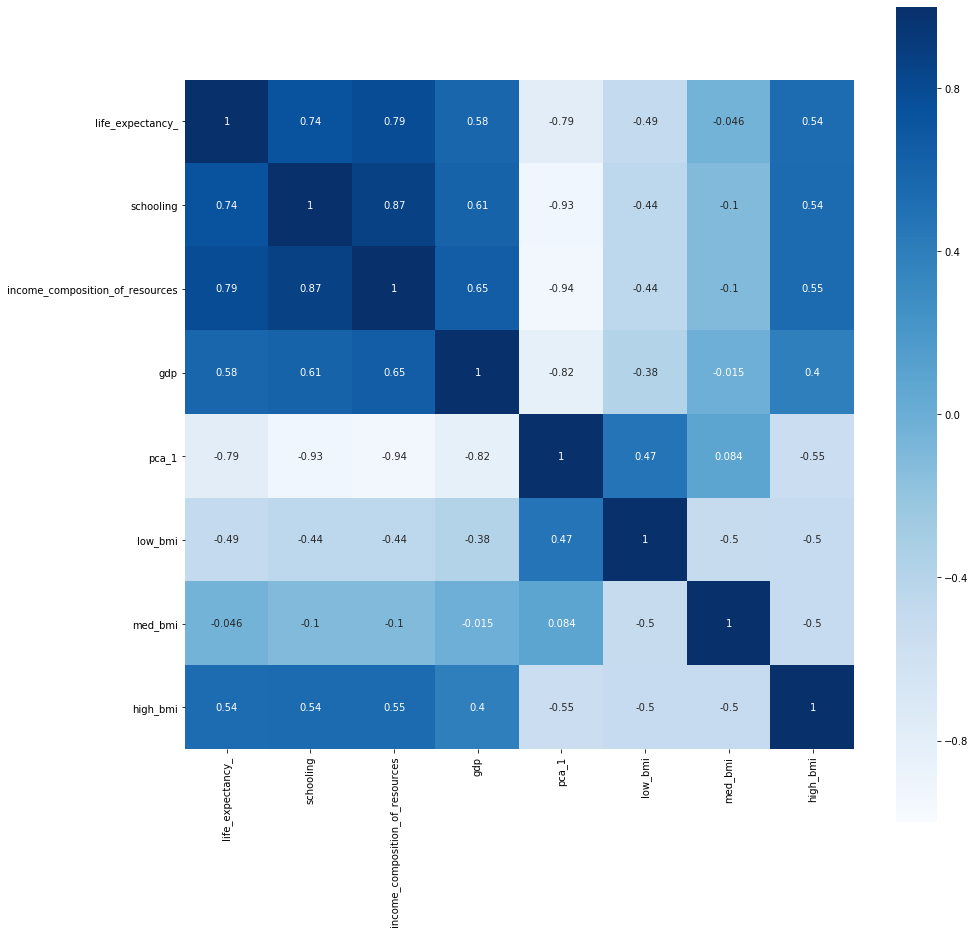

In [262]:
# compare features using a heatmap
plt.figure(figsize=(15, 15))

ax = sns.heatmap(life_exp_features.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, annot=True, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

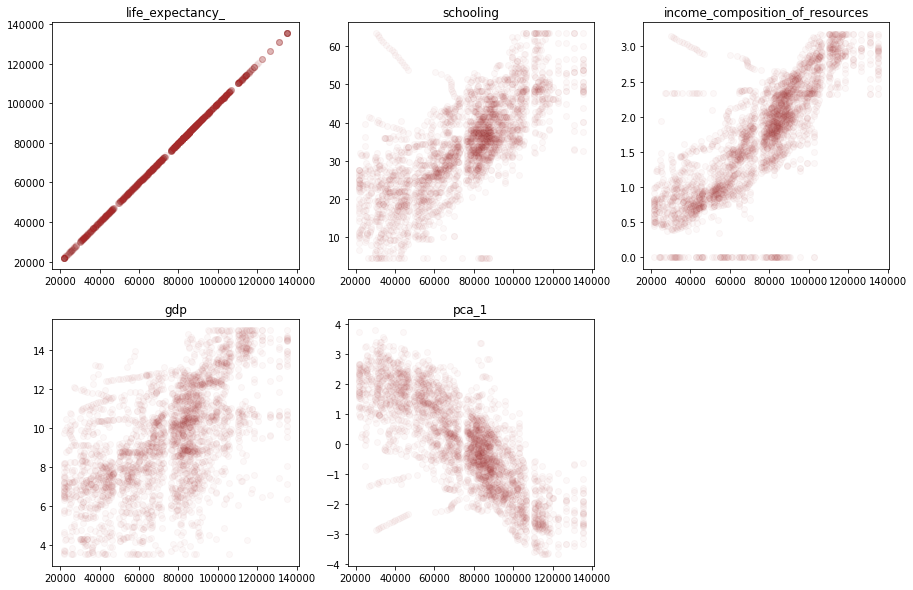

In [276]:
# scatterplot comparison between top features
fig = plt.figure(figsize=(15, 10))

for i, column in enumerate(life_exp_features.columns[:5]):
    plt.subplot(2, 3, i+1)
    plt.title(column)
    plt.scatter(life_exp['life_expectancy_'], life_exp[column], color='brown', alpha=.03);